[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vaibh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vaibh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


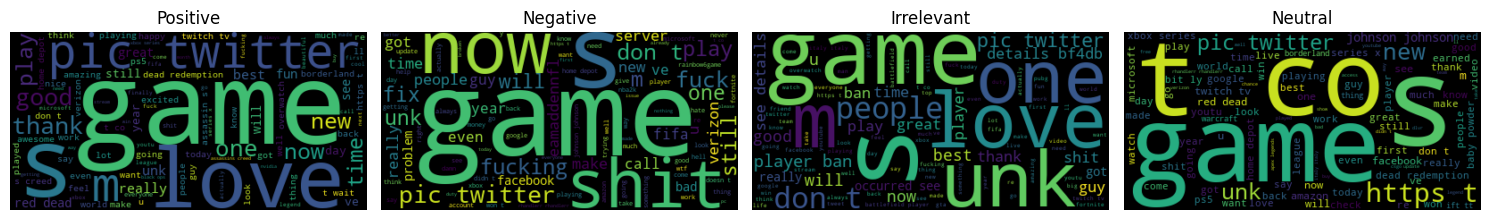

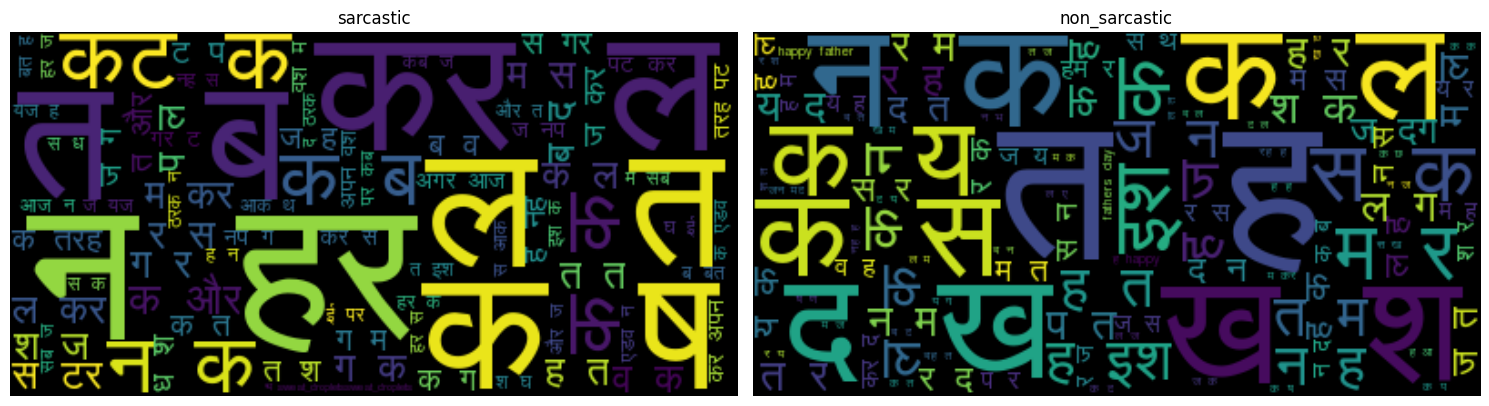

c:\Users\vaibh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\vaibh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


English Model Test Accuracy:  83.65133560956015


c:\Users\vaibh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Hindi Model Test Accuracy:  100.0
Models saved for use in Flask application.


In [4]:
# Consolidated Notebook: Twitter (English) & Hindi Sentiment Analysis

# Importing necessary libraries
import numpy as np
import pandas as pd
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import emoji
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import pickle

# Setup for nltk downloads
nltk.download('stopwords')
nltk.download('punkt')

# Load English Twitter dataset
train = pd.read_csv("twitter_training.csv", header=None)
val = pd.read_csv("twitter_validation.csv", header=None)
train.columns = ['id', 'information', 'type', 'text']
val.columns = ['id', 'information', 'type', 'text']

# Load Hindi dataset
df_sarcastic = pd.read_csv('Hindi_Tweets-SARCASTIC.csv')
df_non_sarcastic = pd.read_csv('Hindi_Tweets-NON-SARCASTIC.csv')
df_sarcastic['label'] = 'sarcastic'
df_non_sarcastic['label'] = 'non_sarcastic'
hindi_df = pd.concat([df_sarcastic, df_non_sarcastic], axis=0).reset_index(drop=True)
hindi_df.drop(['username', 'acctdesc', 'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 
               'tweetcreatedts', 'retweetcount', 'hashtags'], axis=1, inplace=True)

# === 1. Text Preprocessing ===

# --- English Preprocessing ---
def preprocess_english_data(df):
    df['lower'] = df['text'].str.lower().fillna('').astype(str)
    df['lower'] = df['lower'].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
    return df

train = preprocess_english_data(train)
val = preprocess_english_data(val)

# --- Hindi Preprocessing ---
def preprocess_hindi_data(df):
    df['text'] = df['text'].apply(lambda x: emoji.demojize(x))
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].apply(lambda x: re.sub(r'[.!:?\-\'"/]', '', x))
    stopwords_hi = ['तुम', 'मेरी', 'मुझे', 'क्योंकि', 'हम'] # Add more stopwords here as in hindi.ipynb
    stopwords_en = nltk.corpus.stopwords.words('english')
    punctuations = ['nn', 'n', '।', '/', '`', '+', '\\', '"', '?', '▁(', '$', '@', '[', '_', "'", '!', ',', ':', '^', '|', ']', '=', '%', '&', '.', ')', '(', '#', '*', '', ';', '-', '}', '|', '"']
    to_be_removed = stopwords_hi + stopwords_en + punctuations
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in to_be_removed]))
    return df

hindi_df = preprocess_hindi_data(hindi_df)

# === 2. Visualization ===
# Function for plotting word clouds with adjustable label column
def plot_wordclouds(df, text_column, label_column, labels, font_path=None):
    fig, axes = plt.subplots(1, len(labels), figsize=(15, 5))
    for i, label in enumerate(labels):
        # Filter data by label column instead of hardcoding 'type'
        text = ' '.join(df[df[label_column] == label][text_column])
        wordcloud = WordCloud(font_path=font_path, background_color="black", max_words=100).generate(text)
        axes[i].imshow(wordcloud, interpolation="bilinear")
        axes[i].axis("off")
        axes[i].set_title(label)
    plt.tight_layout()
    plt.show()

# Generate word clouds for English Twitter data
plot_wordclouds(train, 'lower', 'type', ["Positive", "Negative", "Irrelevant", "Neutral"])

# Generate word clouds for Hindi data (use 'label' column)
plot_wordclouds(hindi_df, 'text', 'label', ["sarcastic", "non_sarcastic"], font_path="Gargi.ttf")


# === 3. Model Training ===

# --- English Model ---
stop_words_eng = nltk.corpus.stopwords.words('english')
bow_counts_eng = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words_eng, ngram_range=(1, 1))

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(train['lower'], train['type'], test_size=0.2, random_state=0)
X_train_bow_eng = bow_counts_eng.fit_transform(X_train_eng)
X_test_bow_eng = bow_counts_eng.transform(X_test_eng)

model_english = LogisticRegression(C=1, solver="liblinear", max_iter=1000)
model_english.fit(X_train_bow_eng, y_train_eng)
eng_accuracy = accuracy_score(y_test_eng, model_english.predict(X_test_bow_eng))
print("English Model Test Accuracy: ", eng_accuracy * 100)

# Save English model and vectorizer
with open('english_model.pkl', 'wb') as f:
    pickle.dump(model_english, f)
with open('bow_vectorizer_english.pkl', 'wb') as f:
    pickle.dump(bow_counts_eng, f)

# --- Hindi Model ---
from indicnlp.tokenize import indic_tokenize
bow_counts_hindi = CountVectorizer(tokenizer=indic_tokenize.trivial_tokenize, ngram_range=(1, 1))

X_train_hindi, X_test_hindi, y_train_hindi, y_test_hindi = train_test_split(hindi_df['text'], hindi_df['label'], test_size=0.2, random_state=0)
X_train_bow_hindi = bow_counts_hindi.fit_transform(X_train_hindi)
X_test_bow_hindi = bow_counts_hindi.transform(X_test_hindi)

model_hindi = LogisticRegression(C=1, solver="liblinear", max_iter=1000)
model_hindi.fit(X_train_bow_hindi, y_train_hindi)
hindi_accuracy = accuracy_score(y_test_hindi, model_hindi.predict(X_test_bow_hindi))
print("Hindi Model Test Accuracy: ", hindi_accuracy * 100)

# Save Hindi model and vectorizer
with open('hindi_model.pkl', 'wb') as f:
    pickle.dump(model_hindi, f)
with open('bow_vectorizer_hindi.pkl', 'wb') as f:
    pickle.dump(bow_counts_hindi, f)

print("Models saved for use in Flask application.")
